# reaching_go_spout_bar_nov22

Quick analysis of instrumental reaching

additional package depedencies: seaborn, papermill

In [17]:
# allow for automatic reloading of classes and function when updating the code
%load_ext autoreload
%autoreload 2 

# Import Session and Experiment class with helper functions
from trialexp.process.data_import import *
from trialexp.process.pycontrol.utils import *
import seaborn as sns


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load files


Specify the pycontrol file you want to load

In [172]:
# Only analyze an experimental session

# pycontrol_dir = 'Z:\\Teris\\ASAP\\pycontrol\\reaching_go_spout_nov22\\'
# filename = 'kms062-2023-02-06-112451.txt'

pycontrol_dir = 'Z:\\Julien\\Data\\head-fixed\\pycontrol\\reaching_go_spout_bar_nov22\\'
filename = 'kms063-2023-02-10-152938.txt'


### Parameters

In [179]:
# the state and event name that used to separate behavior into trials
trigger = ('hold_for_water','state_change')

# state and event name that used to indicate a successful trial
success = ('busy_win', 'US_delay_timer')

# state and event name that indicate a spout touch
spout_touch = ('waiting_for_spout', 'spout')

### Analyze events and state

In [180]:
#Create experiment object
exp_cohort = Experiment(pycontrol_dir+filename, update = True) #TODO
session = exp_cohort.sessions[0]

# Parse event data
df_events = parse_events(session)

# separate into trials
df_events = add_trial_number(df_events, trigger)
df_events.time = df_events.time /1000 # convert time to s
df_events

,state,event_name,time,trial_number
1,break_after_trial,state_change,0.000,0
2,break_after_trial,CS_offset_timer,2.000,0
4,waiting_for_bar,state_change,9.426,0
7,waiting_for_bar,bar,21.397,0
8,waiting_for_bar,bar_off,21.447,0
...,...,...,...,...
3125,hold_for_water,hold_timer,2051.867,101
3126,waiting_for_spout,state_change,2051.867,101
3128,waiting_for_spout,action_win_timer,2057.867,101
3129,break_after_trial,state_change,2057.870,101


## Analyze the first spout time

In [181]:
#Find first spout time
spouts = df_events[(df_events.state==spout_touch[0]) & (df_events.event_name ==spout_touch[1])].copy()
df_first_spout = spouts.loc[spouts.groupby('trial_number').time.idxmin()]
df_first_spout = df_first_spout.set_index('trial_number')

# find the trial start time
df_trial_start = df_events[(df_events.state==trigger[0]) & (df_events.event_name == trigger[1])].copy()
df_trial_start = df_trial_start.set_index('trial_number')


#calculate the time between the start of trial and first spout touch
df_spout_time = (df_first_spout.time - df_trial_start.time)
df_trial_start['time_first_spout'] = df_spout_time


# Analyze rewards

In [182]:
df_reward = df_events[(df_events.state ==success[0]) & (df_events.event_name == success[1])]
df_reward_num = df_reward.groupby('trial_number').event_name.count()
df_trial_start['num_rewards'] = df_reward_num

## Plotting

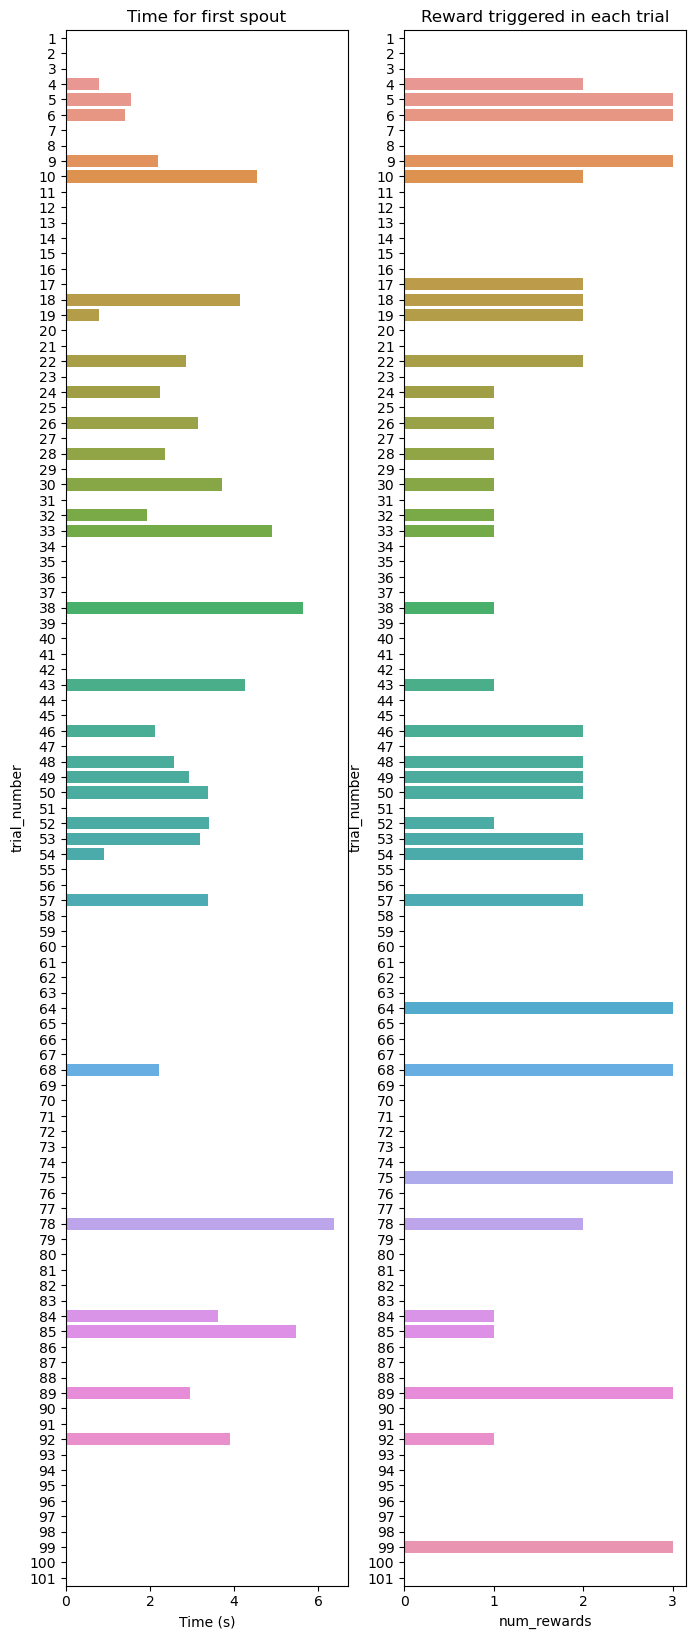

<Figure size 800x1200 with 0 Axes>

In [183]:
df2plot = df_trial_start.reset_index()
df2plot['trial_number'] = df2plot['trial_number'].astype(str) # hack to force it into categorical variable
df2plot

height = len(df2plot)*0.2
fig,ax = plt.subplots(1,2,figsize=(8,height))

sns.barplot( y='trial_number', x='time_first_spout', data=df2plot, ax=ax[0])
ax[0].set(xlabel='Time (s)',title='Time for first spout');

plt.figure(figsize=(8,12))
sns.barplot(y='trial_number', x='num_rewards', data=df2plot, ax = ax[1])
ax[1].set(title='Reward triggered in each trial');



### Summary statistics

In [184]:
print(f'Total reward: {df_trial_start.num_rewards.sum()}')
print(f'Total trials: {df_events.iloc[-1].trial_number}')

#Calculate overall success rate
success_rate = df_trial_start.time_first_spout.notna().mean()
print(f'Success rate: {success_rate}')

#average reward recieved per trial
average_reward = df_trial_start.num_rewards.sum()/df_events.iloc[-1].trial_number
print(f'Average reward per trial: {average_reward}')

#average time to first spout in waiting_for_spout
print(f'Average first spout time {df_trial_start.time_first_spout.mean():.2f}s')

Total reward: 64.0
Total trials: 101
Success rate: 0.297029702970297
Average reward per trial: 0.6336633663366337
Average first spout time 3.09s


# Event plots

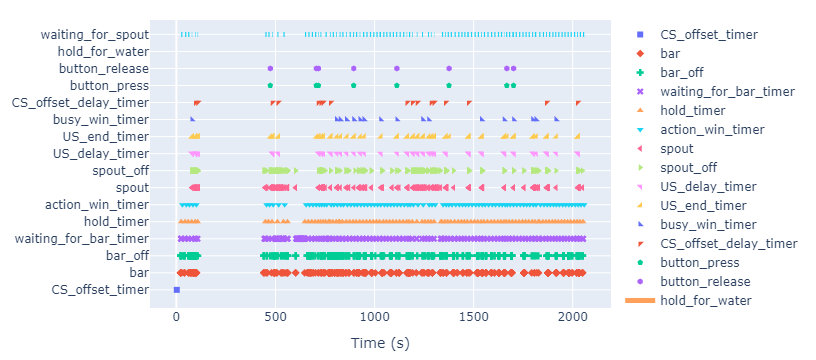

In [188]:

# state_def = [{'name': 'hold_for_water', 
#                   'onset': 'hold_for_water', 'offset': 'waiting_for_spout'},
#             {'name': 'waiting_for_spout', 
#                  'onset': 'waiting_for_spout', 'offset': 'busy_win'},
#             {'name': 'busy_win', 
#                  'onset': 'busy_win', 'offset': 'break_after_water'},
#             {'name': 'break_after_water', 
#                  'onset': 'break_after_water',    'offset': 'waiting_for_bar'},
#             {'name': 'break_after_no_water', 
#                  'onset': 'break_after_no_water', 'offset': 'waiting_for_bar'}]

state_def = [
            {'name': 'hold_for_water', 
                 'onset': 'hold_for_water', 'offset': 'waiting_for_spout'},
            {'name': 'waiting_for_spout', 
                 'onset': 'waiting_for_spout', 'offset': 'break_after_trial'}]

df2plot = df_events[~df_events.event_name.str.contains('Print@') ]# remove all print statement

keys = df2plot.event_name.unique()
keys = keys[keys!='state_change']

plot_session(df2plot, keys, state_def)